In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (13,8)
import random as rand
from pandas import DataFrame, read_csv
import pandas as pd
import geoplotlib
from geoplotlib.utils import BoundingBox
from geoplotlib.colors import ColorMap
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from math import sqrt
import itertools

In [2]:
# Path and filename contain the route to the file
table = pd.read_csv(path+filename)

In [3]:
data = table[table['Category'] == 'PROSTITUTION']
data = data[data['Y'] != 90.0]
list_of_lat = data["Y"]
# List of crimes longitudes
list_of_long = data["X"]
# geoplotlib format
geo_data_for_plotting = {"lat": list_of_lat,
                         "lon": list_of_long}
# To get a map only of SF
bbox = BoundingBox(north=max(list_of_lat), west=min(list_of_long), south=min(list_of_lat), east=max(list_of_long))
geoplotlib.set_bbox(bbox)
# Map style
geoplotlib.tiles_provider('watercolor')
# Draw the map with the data
geoplotlib.kde(geo_data_for_plotting, bw=5, cmap='jet', cut_below=1e-4)
geoplotlib.inline()

('smallest non-zero count', 7.1647865443840454e-10)
('max count:', 10.918804735494032)


In [4]:
# List of latitude-longitude pairs of all points.
X = np.array(zip(list_of_lat,list_of_long))

# K-means i calculated for each number of clusters
n_clusters = range(2,11)
means = [KMeans(n_clusters=i, random_state=0).fit(X) for i in n_clusters]

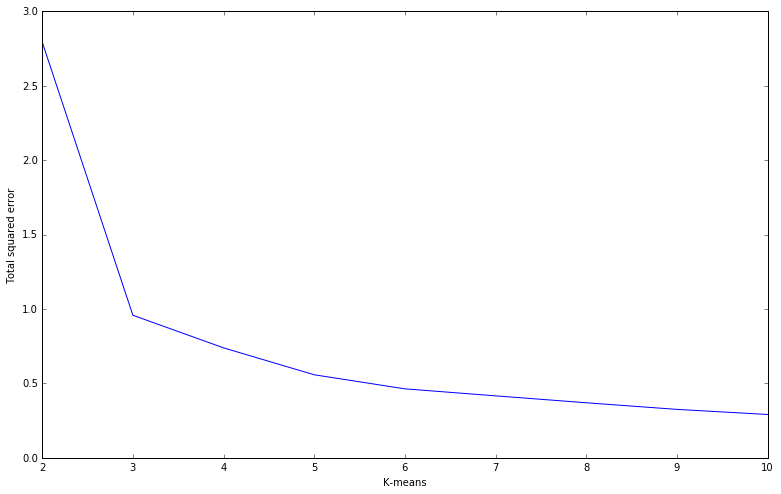

In [5]:
# List containing the list of center for each number of clusters
means_centers = [means[i].cluster_centers_ for i in xrange(len(n_clusters))]
# Total error calculated as the sum of squared distances from each point to the corresponding cluster center
total_error = [np.sum([np.linalg.norm(X[i]-means_centers[k][means[k].labels_[i]])**2 for i in xrange(len(X))]) for k in xrange(len(n_clusters))]

plt.plot(n_clusters, total_error)
plt.xlabel("K-means")
plt.ylabel("Total squared error")
plt.show()

We can see that the total squared error continuously decreases when we add more means. However, it is important to stop at the knee point (at K=3) in order to avoid overfitting. In overfitting, a statistical model describes random error or noise instead of the underlying relationship. Moreover,  a model that has been overfit has poor predictive performance, as it overreacts to minor fluctuations in the training data.

In [6]:
N = 10
lats = X[:,0]
longs = X[:,1]
grid_size = 20
max_lat = max(lats)
min_lat = min(lats)
max_long = max(longs)
min_long = min(longs)

# Grid definition
grid_x = np.linspace(min_long, max_long, grid_size+1)
grid_y = np.linspace(max_lat, min_lat, grid_size+1)
grid = np.meshgrid(grid_x, grid_y)
# Stability matrix
c = np.array([[[0]*grid_size**2 for _ in xrange(len(n_clusters))] for _ in xrange(N)])

stop = False
for k in xrange(N):
    i = 0
    for n in n_clusters:
        # We choose randomly half of the points
        rand_data = rand.sample(X, len(X)// 2)
        # We calculate the clusters
        centers = KMeans(n_clusters=n, random_state=0).fit(rand_data).cluster_centers_.tolist()
        for center in centers:
            row = 1;
            col = 1;
            j = 1
            while(j <= grid_size**2):
                # Grid cell limits
                x_min = grid[0][row-1][col-1]
                x_max = grid[0][row][col]
                y_min = grid[1][row][col]
                y_max = grid[1][row-1][col-1]
                # If we found a center inside a cell we add it to the matrix
                if (center[1] >= x_min and center[1] <= x_max) and (center[0] >= y_min and center[0] <= y_max): 
                    c[k][i][j-1] += 1
                # When we reach the last cell of a row we move to the next one
                if col == grid_size:
                    row += 1
                    col = 0   

                col += 1
                j += 1
        i += 1

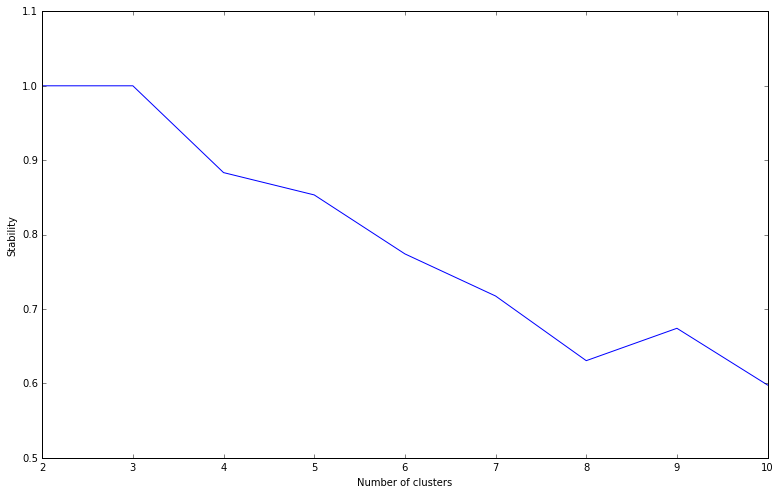

In [7]:
stability = [0]*len(n_clusters)
for i in  xrange(len(n_clusters)):
    pairs = list(itertools.combinations(c[:,i,:],2))
    # We calculate the stability as the average pairwise similarity between N clusterings
    stability[i] = np.mean([cosine_similarity(pair[0].reshape(1,-1), pair[1].reshape(1,-1)) for pair in pairs])
plt.plot(n_clusters, stability)
plt.xlabel("Number of clusters")
plt.ylabel("Stability")
plt.show()

Stability measures how an algorithm is affected by small changes in its inputs, and it is high when the prediction is not highly affected by these changes. In this experiment, we have taken randomly the 50% of the dataset 10 times. Each of these selections will only have slight differences with one another. 

In this plot we can see the evolution of the stability as a function of the number of clusters. We can see that it is maximum for K=2 and K=3. As K=3 is the knee-point of the total squared error plot, the optimal number of clusters is 3.